**Aaptive SINDy**

In [1]:
import os
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import matplotlib.pyplot as plt
import scipy
import vtk
from vtk.util import numpy_support as VN
from itertools import combinations

Here, we consider a unsteady flow inside a symmetric stenosed coronary artery computed by imposing time-varying inlet flow rate using an open sourced - SimVascular FEM fluid solver. The post-stenoic velocity flow field over a grid of 512X512 is used for the project work. 

In [2]:
x_dim = 512
y_dim = 512
data_file = "data_"
directory = os.getcwd()  # GET THE CURRENT WORKING DIRECTORY  
path      = directory + '/'
data_file = path + data_file
Nfiles    = 100

In [3]:
fieldname  = 'Vmag'
Vel_data   = np.zeros((x_dim*y_dim, Nfiles))

for i in range(Nfiles):
    file_name = data_file + str(i) + ".vtk"
    print ('READING THE DATA FILE: ', file_name[len(directory)+1:])
    reader = vtk.vtkStructuredGridReader()
    reader.SetFileName(file_name)
    reader.Update()
    data = reader.GetOutput()
    pointData = data.GetPointData().GetArray(fieldname)
    velocity  = np.reshape(VN.vtk_to_numpy(pointData), (1, x_dim*y_dim))
    Vel_data [:, i] = (2.0*velocity - np.min(velocity) - np.max(velocity))/ (np.max(velocity) - np.min(velocity))
    print ("*"*85)


READING THE DATA FILE:  data_0.vtk
*************************************************************************************
READING THE DATA FILE:  data_1.vtk
*************************************************************************************
READING THE DATA FILE:  data_2.vtk
*************************************************************************************
READING THE DATA FILE:  data_3.vtk
*************************************************************************************
READING THE DATA FILE:  data_4.vtk
*************************************************************************************
READING THE DATA FILE:  data_5.vtk
*************************************************************************************
READING THE DATA FILE:  data_6.vtk
*************************************************************************************
READING THE DATA FILE:  data_7.vtk
*************************************************************************************
READING THE DATA FILE:  data_8.v

*************************************************************************************
READING THE DATA FILE:  data_74.vtk
*************************************************************************************
READING THE DATA FILE:  data_75.vtk
*************************************************************************************
READING THE DATA FILE:  data_76.vtk
*************************************************************************************
READING THE DATA FILE:  data_77.vtk
*************************************************************************************
READING THE DATA FILE:  data_78.vtk
*************************************************************************************
READING THE DATA FILE:  data_79.vtk
*************************************************************************************
READING THE DATA FILE:  data_80.vtk
*************************************************************************************
READING THE DATA FILE:  data_81.vtk
************************

First, we normalize the temporal velocity data by its spatially averaged mean value at a given time instant. Then, the matrix size is transformed to a square matrix, thereby computing the SVD operation more efficiently.

In [4]:
U, E, V  = np.linalg.svd(Vel_data, full_matrices=False)
Eigen_val = np.sqrt(E)

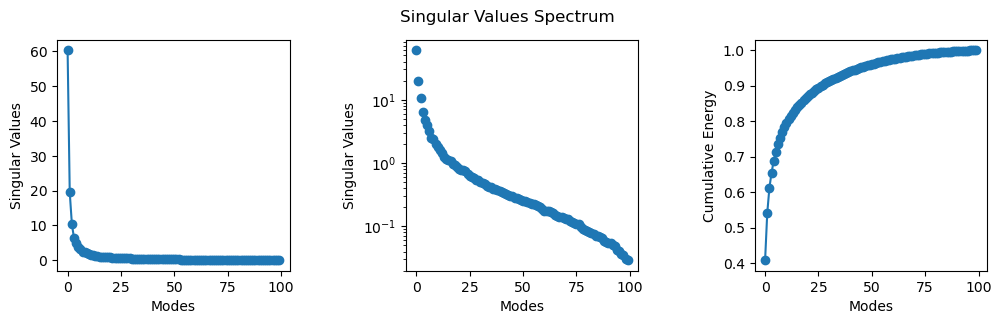

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize =(12, 3))
fig.suptitle('Singular Values Spectrum')

ax[0].plot(Eigen_val, '-o')
ax[0].set(xlabel="Modes",ylabel="Singular Values")

ax[1].plot(Eigen_val, 'o')
ax[1].set(xlabel="Modes",ylabel="Singular Values")
ax[1].set_yscale('log')

ax[2].plot(np.cumsum(Eigen_val)/np.sum(Eigen_val), '-o')
ax[2].set(xlabel="Modes",ylabel="Cumulative Energy")
fig.subplots_adjust(wspace=0.5)

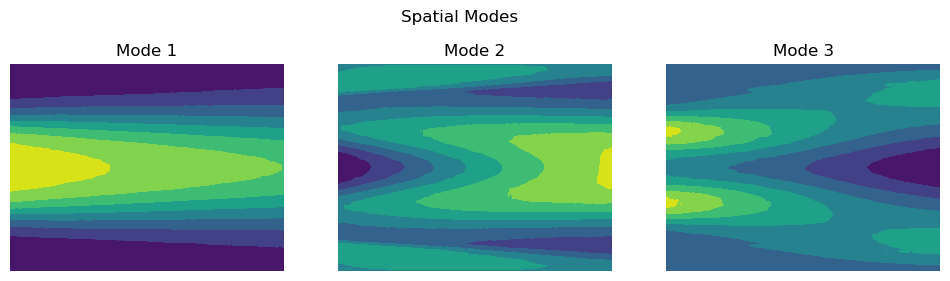

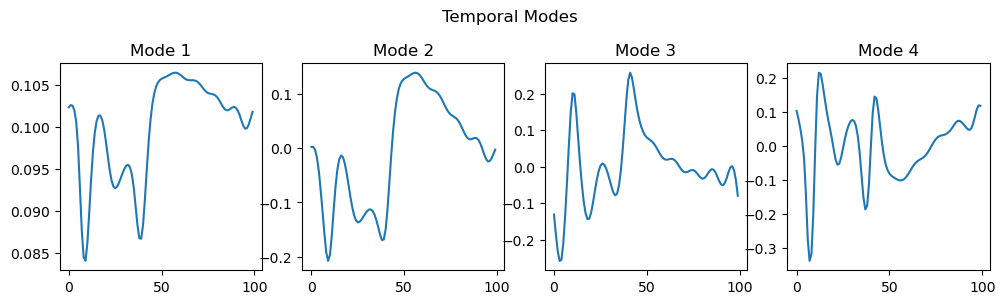

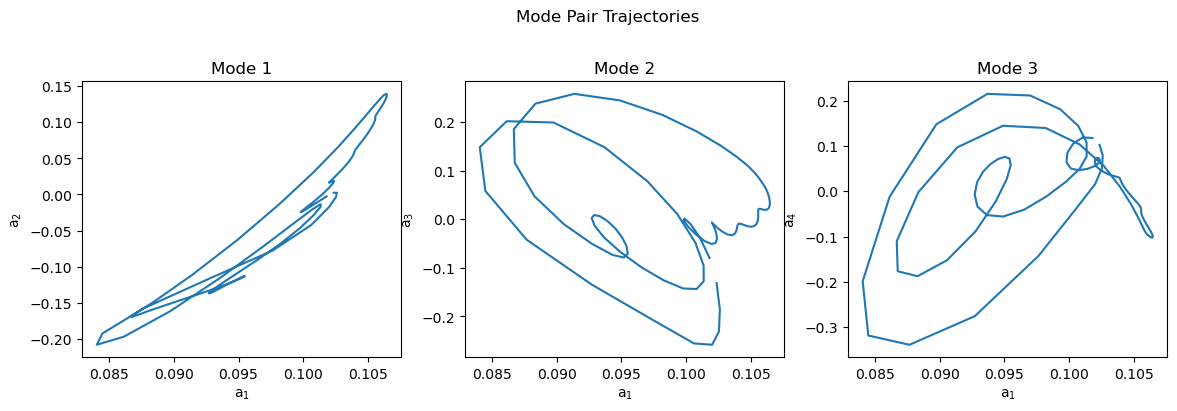

In [6]:
mode1 = np.reshape(U[:, 0], (x_dim, y_dim))
mode2 = np.reshape(U[:, 1], (x_dim, y_dim))
mode3 = np.reshape(U[:, 2], (x_dim, y_dim))

coeff1 = V [0, :]
coeff2 = V [1, :]
coeff3 = V [2, :]
coeff4 = V [3, :]

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize =(12, 3))
fig.suptitle('Spatial Modes')

ax[0].contourf(mode1) 
ax[0].set_title('Mode 1')
ax[0].axis('off')

ax[1].contourf(mode2) 
ax[1].set_title('Mode 2')
ax[1].axis('off')

ax[2].contourf(mode3) 
ax[2].set_title('Mode 3')
ax[2].axis('off')
fig.subplots_adjust(top=0.8)

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize =(12, 3))
fig.suptitle('Temporal Modes')

ax[0].plot(coeff1) 
ax[0].set_title('Mode 1')

ax[1].plot(coeff2)
ax[1].set_title('Mode 2')


ax[2].plot(coeff3)
ax[2].set_title('Mode 3')

ax[3].plot(coeff4)
ax[3].set_title('Mode 4')

fig.subplots_adjust(top=0.8)



fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize =(14, 4))
fig.suptitle('Mode Pair Trajectories')

ax[0].plot(coeff1, coeff2) 
ax[0].set_title('Mode 1')
ax[0].set_xlabel('$\mathregular{a_1}$')
ax[0].set_ylabel('$\mathregular{a_2}$')

ax[1].plot(coeff1, coeff3)
ax[1].set_title('Mode 2')
ax[1].set_xlabel('$\mathregular{a_1}$')
ax[1].set_ylabel('$\mathregular{a_3}$')

ax[2].plot(coeff1, coeff4)
ax[2].set_title('Mode 3')
ax[2].set_xlabel('$\mathregular{a_1}$')
ax[2].set_ylabel('$\mathregular{a_4}$')
fig.subplots_adjust(top=0.8)

SINDy computation starts from here, utilizing the computed PCA modes.

In [7]:
processor = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("AVAILABLE PROCESSOR:", processor, '\n')

N_modes     = 3
modes       = torch.Tensor(V [:N_modes, :]).to(processor)

# HYPERPARAMETERS FOR THE SINDy POD METHODOLOGY
Epochs        = 15000
learning_rate = 1e-3
step_epoch    = 3500
decay_rate    = 0.50

N_terms = math.comb(N_modes, 1) + math.comb(N_modes, 2) + math.comb(N_modes, 3) + N_modes

# COMPUTING THE COMBINATIONS AMONG THE THREE CHOSEN TEMPORAL MODES
A1 = modes [0, :].reshape(1, -1)
A2 = modes [1, :].reshape(1, -1)
A3 = modes [2, :].reshape(1, -1)

A1A2   = (A1*A2).reshape(1, -1) 
A2A3   = (A2*A3).reshape(1, -1)
A3A1   = (A3*A1).reshape(1, -1)

A11A2  = (A1*A1*A2).reshape(1, -1) 
A22A3  = (A2*A2*A3).reshape(1, -1)
A33A1  = (A3*A3*A1).reshape(1, -1)

A1A22  = (A1*A2*A2).reshape(1, -1) 
A2A33  = (A2*A3*A3).reshape(1, -1)
A3A11  = (A3*A1*A1).reshape(1, -1)

A1A2A3 = (A1*A2*A3).reshape(1, -1)

A11A2A3 = (A1*A1*A2*A3).reshape(1, -1)
A1A22A3 = (A1*A2*A2*A3).reshape(1, -1)
A1A2A33 = (A1*A2*A3*A3).reshape(1, -1)

A11A22A3 = (A1*A1*A2*A2*A3).reshape(1, -1)
A1A22A33 = (A1*A2*A2*A3*A3).reshape(1, -1)
A11A2A33 = (A1*A1*A2*A3*A3).reshape(1, -1)

A_candidates = torch.transpose(torch.vstack ((torch.ones_like(A1), A1, A2, A3, A1A2, A2A3, A3A1, A11A2, A22A3, A33A1, A1A22, A2A33, A3A11, A1A2A3,
                              A11A2A3, A1A22A3, A1A2A33, A11A22A3, A1A22A33, A11A2A33)), 0, 1)
print(A_candidates.shape)                             


AVAILABLE PROCESSOR: cuda 

torch.Size([100, 20])


In [8]:
def DERIVATIVE(a, Nfiles):
    dadt = torch.zeros_like(a)
    for i in range(Nfiles-1):
        dadt [:, i] = a[:, i+1] - a[:, i]
    dadt [:, -1] = a[:, -2] - a[:, -1]
    return dadt

class SINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b
        
    def forward(self, x):
        output = torch.sin(self.b*x)
        return output
    
class COSINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b
        
    def forward(self, x):
        output = torch.cos(self.b*x)
        return output

In [9]:
class SINDy_MODEL(nn.Module):
    def __init__(self, a, asine, acosine):
        super().__init__()    
        self.a        = a
        self.asine    = asine
        self.acosine  = acosine
        self.sine     = SINE_TERM (self.asine)
        self.cosine   = COSINE_TERM (self.acosine)
        
    def forward(self, x):
        output_sine    = self.sine   (x)
        output_cosine  = self.cosine (x)
        output = torch.hstack((x, output_sine, output_cosine)) @ self.a
        return output

In [10]:
# AMPLITUDE COEFFICIENTS OF SINDy MODEL
N_terms = 3

COEFF_ADT  = torch.ones(N_terms*A_candidates.shape[1], N_modes, requires_grad= True, device= processor)
SINE_ADT   = torch.ones(A_candidates.shape[1], N_modes, requires_grad= True, device= processor)
COSINE_ADT = torch.ones(A_candidates.shape[1], N_modes, requires_grad= True, device= processor)

In [11]:
# COEFFICIENTS OF SINDy MODEL
optim_COEFF_ADT = optim.Adam([COEFF_ADT, SINE_ADT, COSINE_ADT],  lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

# WEIGHT FUNCTION OF SINDy MODEL
W_FUNCTION   = Parameter(torch.ones_like(COEFF_ADT), requires_grad= True)
optim_Lambda = optim.Adam([W_FUNCTION], lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)

# STEP DECAY DYNAMIC LEARNING RATE
scheduler_COEFF_ADT = torch.optim.lr_scheduler.StepLR(optim_COEFF_ADT, step_size=step_epoch, gamma=decay_rate)
scheduler_LAMBDA    = torch.optim.lr_scheduler.StepLR(optim_Lambda,    step_size=step_epoch, gamma=decay_rate)

In [12]:
A1A2A3_time_deriv = DERIVATIVE (modes, Nfiles)

# TEMPORAL MODE 1
A1_DT = SINDy_MODEL(COEFF_ADT [:, 0], SINE_ADT [:, 0], COSINE_ADT[:, 0]).to(processor)

# TEMPORAL MODE 2
A2_DT = SINDy_MODEL(COEFF_ADT [:, 1], SINE_ADT [:, 1], COSINE_ADT[:, 1]).to(processor)

# TEMPORAL MODE 3
A3_DT = SINDy_MODEL(COEFF_ADT [:, 2], SINE_ADT [:, 2], COSINE_ADT[:, 2]).to(processor)

Loss_data     = torch.empty(size=(Epochs, 1))
loss_function = nn.MSELoss()

for epoch in range(Epochs):
    A1_out, A2_out, A3_out  = A1_DT (A_candidates), A2_DT (A_candidates), A3_DT (A_candidates)
    output_data  = torch.vstack((A1_out , A2_out, A3_out))
    loss_epoch   = loss_function (A1A2A3_time_deriv, output_data) + torch.linalg.matrix_norm(torch.abs(W_FUNCTION)*COEFF_ADT, ord =1)
    
    optim_COEFF_ADT.zero_grad()
    optim_Lambda.zero_grad()
    loss_epoch.backward()

    with torch.no_grad():
        optim_COEFF_ADT.step()
        optim_Lambda.step()
        Loss_data [epoch] = loss_epoch.detach()
        
    print('LOSS DATA, [EPOCH =', epoch,  ']:',  Loss_data [epoch].item())
    print('LEARNING RATE:', optim_COEFF_ADT.param_groups[0]['lr'])
    print ("*"*85)
       
    scheduler_COEFF_ADT.step()
    scheduler_LAMBDA.step()


LOSS DATA, [EPOCH = 0 ]: 524.9793701171875
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1 ]: 523.8644409179688
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2 ]: 522.7507934570312
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3 ]: 521.6384887695312
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 4 ]: 520.5274658203125
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 5 ]: 519.417724609375
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 6 ]: 518.3095092773438
LEARNING RATE: 0.001
*************************************

LOSS DATA, [EPOCH = 64 ]: 457.875732421875
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 65 ]: 456.89794921875
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 66 ]: 455.9183654785156
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 67 ]: 454.9382629394531
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 68 ]: 453.9607238769531
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 69 ]: 452.9951477050781
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 70 ]: 452.0202331542969
LEARNING RATE: 0.001
********************************

LOSS DATA, [EPOCH = 163 ]: 368.37664794921875
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 164 ]: 367.5433349609375
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 165 ]: 366.7095947265625
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 166 ]: 365.87762451171875
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 167 ]: 365.0484619140625
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 168 ]: 364.2247314453125
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 169 ]: 363.4021301269531
LEARNING RATE: 0.001
********************

LOSS DATA, [EPOCH = 268 ]: 287.9064636230469
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 269 ]: 287.204345703125
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 270 ]: 286.4951477050781
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 271 ]: 285.79486083984375
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 272 ]: 285.0965270996094
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 273 ]: 284.4002990722656
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 274 ]: 283.70611572265625
LEARNING RATE: 0.001
*********************

LOSS DATA, [EPOCH = 363 ]: 226.04331970214844
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 364 ]: 225.4471435546875
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 365 ]: 224.849609375
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 366 ]: 224.24545288085938
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 367 ]: 223.6471405029297
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 368 ]: 223.04830932617188
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 369 ]: 222.46031188964844
LEARNING RATE: 0.001
**********************

LOSS DATA, [EPOCH = 417 ]: 195.0552978515625
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 418 ]: 194.5105743408203
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 419 ]: 193.9650115966797
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 420 ]: 193.41978454589844
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 421 ]: 192.8754119873047
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 422 ]: 192.33432006835938
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 423 ]: 191.7904510498047
LEARNING RATE: 0.001
********************

LOSS DATA, [EPOCH = 525 ]: 141.47726440429688
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 526 ]: 141.03404235839844
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 527 ]: 140.58489990234375
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 528 ]: 140.14849853515625
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 529 ]: 139.7071990966797
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 530 ]: 139.2600860595703
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 531 ]: 138.80796813964844
LEARNING RATE: 0.001
*****************

LOSS DATA, [EPOCH = 629 ]: 99.65853881835938
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 630 ]: 99.2980728149414
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 631 ]: 98.93988800048828
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 632 ]: 98.58745574951172
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 633 ]: 98.23184967041016
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 634 ]: 97.87487030029297
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 635 ]: 97.51825714111328
LEARNING RATE: 0.001
***********************

LOSS DATA, [EPOCH = 731 ]: 67.21128845214844
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 732 ]: 66.94062805175781
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 733 ]: 66.66466522216797
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 734 ]: 66.38408660888672
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 735 ]: 66.09952545166016
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 736 ]: 65.83113098144531
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 737 ]: 65.55900573730469
LEARNING RATE: 0.001
**********************

LOSS DATA, [EPOCH = 831 ]: 42.93624496459961
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 832 ]: 42.729801177978516
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 833 ]: 42.52714538574219
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 834 ]: 42.32094955444336
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 835 ]: 42.11090087890625
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 836 ]: 41.90711212158203
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 837 ]: 41.710289001464844
LEARNING RATE: 0.001
********************

LOSS DATA, [EPOCH = 927 ]: 26.027252197265625
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 928 ]: 25.882871627807617
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 929 ]: 25.735788345336914
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 930 ]: 25.587066650390625
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 931 ]: 25.445409774780273
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 932 ]: 25.30437469482422
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 933 ]: 25.160545349121094
LEARNING RATE: 0.001
****************

LOSS DATA, [EPOCH = 1024 ]: 14.617618560791016
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1025 ]: 14.528362274169922
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1026 ]: 14.43766975402832
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1027 ]: 14.344023704528809
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1028 ]: 14.257098197937012
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1029 ]: 14.171268463134766
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1030 ]: 14.084653854370117
LEARNING RATE: 0.001
*********

LOSS DATA, [EPOCH = 1118 ]: 8.131406784057617
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1119 ]: 8.081099510192871
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1120 ]: 8.032933235168457
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1121 ]: 7.98268985748291
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1122 ]: 7.93629264831543
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1123 ]: 7.890233993530273
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1124 ]: 7.841304779052734
LEARNING RATE: 0.001
*****************

LOSS DATA, [EPOCH = 1209 ]: 4.933428764343262
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1210 ]: 4.9107985496521
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1211 ]: 4.886322975158691
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1212 ]: 4.86328125
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1213 ]: 4.840102672576904
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1214 ]: 4.815546035766602
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1215 ]: 4.791823387145996
LEARNING RATE: 0.001
************************

LOSS DATA, [EPOCH = 1275 ]: 3.7079484462738037
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1276 ]: 3.6935460567474365
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1277 ]: 3.6794307231903076
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1278 ]: 3.6644108295440674
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1279 ]: 3.647632598876953
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1280 ]: 3.6313838958740234
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1281 ]: 3.6201274394989014
LEARNING RATE: 0.001
*********

LOSS DATA, [EPOCH = 1366 ]: 2.624587297439575
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1367 ]: 2.6154587268829346
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1368 ]: 2.604545831680298
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1369 ]: 2.5953824520111084
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1370 ]: 2.5844297409057617
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1371 ]: 2.575690507888794
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1372 ]: 2.5665135383605957
LEARNING RATE: 0.001
***********

LOSS DATA, [EPOCH = 1422 ]: 2.097040891647339
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1423 ]: 2.0883333683013916
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1424 ]: 2.077751398086548
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1425 ]: 2.0687503814697266
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1426 ]: 2.0609729290008545
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1427 ]: 2.0539495944976807
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1428 ]: 2.0447745323181152
LEARNING RATE: 0.001
**********

LOSS DATA, [EPOCH = 1511 ]: 1.3973829746246338
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1512 ]: 1.3902877569198608
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1513 ]: 1.38192880153656
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1514 ]: 1.3738943338394165
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1515 ]: 1.3670594692230225
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1516 ]: 1.3602558374404907
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1517 ]: 1.354825496673584
LEARNING RATE: 0.001
***********

LOSS DATA, [EPOCH = 1608 ]: 0.817939281463623
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1609 ]: 0.813709020614624
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1610 ]: 0.8076111078262329
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1611 ]: 0.8040274977684021
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1612 ]: 0.7988647222518921
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1613 ]: 0.7919708490371704
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1614 ]: 0.7850995659828186
LEARNING RATE: 0.001
**********

LOSS DATA, [EPOCH = 1701 ]: 0.423890084028244
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1702 ]: 0.4210435450077057
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1703 ]: 0.4167071282863617
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1704 ]: 0.4144023358821869
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1705 ]: 0.41092878580093384
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1706 ]: 0.4081200957298279
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1707 ]: 0.4038993716239929
LEARNING RATE: 0.001
********

LOSS DATA, [EPOCH = 1810 ]: 0.15358157455921173
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1811 ]: 0.15070544183254242
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1812 ]: 0.14757117629051208
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1813 ]: 0.14588452875614166
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1814 ]: 0.14453125
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1815 ]: 0.14409707486629486
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1816 ]: 0.14305663108825684
LEARNING RATE: 0.001
**********

LOSS DATA, [EPOCH = 1905 ]: 0.04495927691459656
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1906 ]: 0.04563280567526817
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1907 ]: 0.04487526789307594
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1908 ]: 0.044612493366003036
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1909 ]: 0.042524565011262894
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1910 ]: 0.04209009185433388
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 1911 ]: 0.04163600504398346
LEARNING RATE: 0.001

LOSS DATA, [EPOCH = 2003 ]: 0.008791526779532433
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2004 ]: 0.009554954245686531
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2005 ]: 0.010366883128881454
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2006 ]: 0.009942273609340191
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2007 ]: 0.009755298495292664
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2008 ]: 0.008666619658470154
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2009 ]: 0.007664901670068502
LEARNING RATE: 

LOSS DATA, [EPOCH = 2101 ]: 0.004105656407773495
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2102 ]: 0.004345691297203302
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2103 ]: 0.0038055493496358395
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2104 ]: 0.0036073103547096252
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2105 ]: 0.004450008738785982
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2106 ]: 0.005366777069866657
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2107 ]: 0.004995107650756836
LEARNING RATE

LOSS DATA, [EPOCH = 2197 ]: 0.00292882788926363
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2198 ]: 0.0026346708182245493
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2199 ]: 0.0029439707286655903
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2200 ]: 0.0030532267410308123
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2201 ]: 0.0037941690534353256
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2202 ]: 0.0031578687485307455
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2203 ]: 0.0032839085906744003
LEARNING R

LOSS DATA, [EPOCH = 2319 ]: 0.002988894237205386
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2320 ]: 0.003879979019984603
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2321 ]: 0.003479102859273553
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2322 ]: 0.003408582415431738
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2323 ]: 0.003293041605502367
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2324 ]: 0.0028543320950120687
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2325 ]: 0.003522277809679508
LEARNING RATE:

LOSS DATA, [EPOCH = 2380 ]: 0.0025104437954723835
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2381 ]: 0.002463732613250613
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2382 ]: 0.0028822929598391056
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2383 ]: 0.0024780251551419497
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2384 ]: 0.002316886791959405
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2385 ]: 0.0028777453117072582
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2386 ]: 0.0025717609096318483
LEARNING R

LOSS DATA, [EPOCH = 2483 ]: 0.002433041576296091
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2484 ]: 0.0030310668516904116
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2485 ]: 0.003547567641362548
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2486 ]: 0.0029741607140749693
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2487 ]: 0.0025939124170690775
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2488 ]: 0.002455799374729395
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2489 ]: 0.0024325253907591105
LEARNING RA

LOSS DATA, [EPOCH = 2577 ]: 0.0017364153172820807
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2578 ]: 0.0018287436105310917
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2579 ]: 0.0014828771818429232
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2580 ]: 0.001613333821296692
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2581 ]: 0.0015620682388544083
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2582 ]: 0.0015023768646642566
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2583 ]: 0.0014667387586086988
LEARNING 

LOSS DATA, [EPOCH = 2630 ]: 0.001490670838393271
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2631 ]: 0.00122610863763839
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2632 ]: 0.0014057355001568794
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2633 ]: 0.0011887073051184416
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2634 ]: 0.001261397497728467
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2635 ]: 0.0014626991469413042
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2636 ]: 0.001471791765652597
LEARNING RATE

LOSS DATA, [EPOCH = 2731 ]: 0.0012279311195015907
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2732 ]: 0.0010775793343782425
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2733 ]: 0.0012370124459266663
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2734 ]: 0.0014602241571992636
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2735 ]: 0.0012586270458996296
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2736 ]: 0.0012069318909198046
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2737 ]: 0.0012533102417364717
LEARNING

LOSS DATA, [EPOCH = 2823 ]: 0.0014203570317476988
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2824 ]: 0.0013145121047273278
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2825 ]: 0.0014540089759975672
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2826 ]: 0.0013361405581235886
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2827 ]: 0.0014966469025239348
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2828 ]: 0.0016026253579184413
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2829 ]: 0.0013671983033418655
LEARNING

LOSS DATA, [EPOCH = 2921 ]: 0.000643497274722904
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2922 ]: 0.0006281910464167595
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2923 ]: 0.000685428618453443
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2924 ]: 0.0006457233102992177
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2925 ]: 0.0007075334433466196
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2926 ]: 0.0007747357012704015
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 2927 ]: 0.0006803324795328081
LEARNING R

LOSS DATA, [EPOCH = 3020 ]: 0.0005690025864169002
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3021 ]: 0.0005706701194867492
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3022 ]: 0.00051870197057724
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3023 ]: 0.0005007490399293602
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3024 ]: 0.0005008456064388156
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3025 ]: 0.0004950540605932474
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3026 ]: 0.0004957239143550396
LEARNING R

LOSS DATA, [EPOCH = 3073 ]: 0.0004871432902291417
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3074 ]: 0.00047821924090385437
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3075 ]: 0.0004595588252414018
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3076 ]: 0.0004364807973615825
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3077 ]: 0.0004634794604498893
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3078 ]: 0.00044979556696489453
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3079 ]: 0.00046888567158021033
LEARN

LOSS DATA, [EPOCH = 3139 ]: 0.00044677883852273226
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3140 ]: 0.00043132086284458637
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3141 ]: 0.0004540767695289105
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3142 ]: 0.00044851007987745106
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3143 ]: 0.00043425668263807893
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3144 ]: 0.000401802797568962
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3145 ]: 0.00041283213067799807
LEAR

LOSS DATA, [EPOCH = 3199 ]: 0.00045101402793079615
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3200 ]: 0.0004303934401832521
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3201 ]: 0.00042778291390277445
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3202 ]: 0.00038571536424569786
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3203 ]: 0.0003987052768934518
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3204 ]: 0.00038281313027255237
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3205 ]: 0.00039542518788948655
LEA

LOSS DATA, [EPOCH = 3294 ]: 0.00037294873618520796
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3295 ]: 0.0004190980107523501
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3296 ]: 0.00041925942059606314
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3297 ]: 0.00040756911039352417
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3298 ]: 0.00039161756285466254
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3299 ]: 0.0003807577886618674
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3300 ]: 0.0003843793529085815
LEAR

LOSS DATA, [EPOCH = 3385 ]: 0.00033671222627162933
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3386 ]: 0.00034398934803903103
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3387 ]: 0.00034393047099001706
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3388 ]: 0.00034524028887972236
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3389 ]: 0.00033979900763370097
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3390 ]: 0.00034299548133276403
LEARNING RATE: 0.001
*************************************************************************************
LOSS DATA, [EPOCH = 3391 ]: 0.00034845146001316607
L

LOSS DATA, [EPOCH = 3500 ]: 0.0003369572223164141
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3501 ]: 0.00033712745062075555
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3502 ]: 0.00033254330628551543
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3503 ]: 0.00033258312032558024
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3504 ]: 0.0003328723832964897
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3505 ]: 0.00032739873859100044
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3506 ]: 0.000331998307956382

LOSS DATA, [EPOCH = 3591 ]: 0.000326467037666589
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3592 ]: 0.0003257370844949037
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3593 ]: 0.0003274631453678012
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3594 ]: 0.0003222491650376469
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3595 ]: 0.00032024335814639926
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3596 ]: 0.0003251167363487184
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3597 ]: 0.00031764942104928195
L

LOSS DATA, [EPOCH = 3644 ]: 0.00032709227525629103
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3645 ]: 0.00032834455487318337
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3646 ]: 0.00032448259298689663
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3647 ]: 0.00032497826032340527
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3648 ]: 0.00031748053152114153
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3649 ]: 0.00031792986555956304
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3650 ]: 0.0003171398711856

LOSS DATA, [EPOCH = 3699 ]: 0.0003233776078559458
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3700 ]: 0.00031701684929430485
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3701 ]: 0.0003124919894617051
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3702 ]: 0.00032125975121743977
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3703 ]: 0.0003242065431550145
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3704 ]: 0.00031579181086272
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3705 ]: 0.00031539241899736226
L

LOSS DATA, [EPOCH = 3751 ]: 0.00032085663406178355
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3752 ]: 0.0003132699348498136
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3753 ]: 0.000316014135023579
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3754 ]: 0.0003168866678606719
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3755 ]: 0.00031661754474043846
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3756 ]: 0.00031168528948910534
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3757 ]: 0.0003077085129916668


LOSS DATA, [EPOCH = 3808 ]: 0.00031552364816889167
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3809 ]: 0.0003073717816732824
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3810 ]: 0.0003152214630972594
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3811 ]: 0.00031363434391096234
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3812 ]: 0.00032097529037855566
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3813 ]: 0.0003197986225131899
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3814 ]: 0.0003224297543056309

LOSS DATA, [EPOCH = 3901 ]: 0.0003246905980631709
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3902 ]: 0.00032018052297644317
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3903 ]: 0.0003150536213070154
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3904 ]: 0.00030998216243460774
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3905 ]: 0.00031625511473976076
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3906 ]: 0.00031610135920345783
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3907 ]: 0.000321815052302554

LOSS DATA, [EPOCH = 3994 ]: 0.0003171726712025702
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3995 ]: 0.0003176199097651988
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3996 ]: 0.00031604012474417686
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3997 ]: 0.0003145488153677434
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3998 ]: 0.00031401775777339935
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 3999 ]: 0.00032129004830494523
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4000 ]: 0.0003149838012177497

LOSS DATA, [EPOCH = 4098 ]: 0.0003096209547948092
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4099 ]: 0.00031385087640956044
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4100 ]: 0.0003177284961566329
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4101 ]: 0.0003134456055704504
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4102 ]: 0.0003072796098422259
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4103 ]: 0.00031200688681565225
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4104 ]: 0.00031691291951574385

LOSS DATA, [EPOCH = 4189 ]: 0.00031490661785937846
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4190 ]: 0.00031623494578525424
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4191 ]: 0.00030846084700897336
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4192 ]: 0.0003117486776318401
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4193 ]: 0.0003120877663604915
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4194 ]: 0.00030680751660838723
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4195 ]: 0.000315332581521943

LOSS DATA, [EPOCH = 4251 ]: 0.0003093653649557382
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4252 ]: 0.0003124685026705265
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4253 ]: 0.0003124432696495205
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4254 ]: 0.0003118361346423626
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4255 ]: 0.00031331481295637786
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4256 ]: 0.0003082536277361214
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4257 ]: 0.0003073380212299526
L

LOSS DATA, [EPOCH = 4346 ]: 0.00031177460914477706
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4347 ]: 0.000310581672238186
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4348 ]: 0.0003056045388802886
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4349 ]: 0.0003089464153163135
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4350 ]: 0.00031282982672564685
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4351 ]: 0.00030963672907091677
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4352 ]: 0.0003125939692836255


LOSS DATA, [EPOCH = 4433 ]: 0.0003082243783865124
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4434 ]: 0.00030910992063581944
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4435 ]: 0.0003117640153504908
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4436 ]: 0.00031250552274286747
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4437 ]: 0.00031519957701675594
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4438 ]: 0.0003108414530288428
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4439 ]: 0.0003111541445832699

LOSS DATA, [EPOCH = 4554 ]: 0.00031014924752525985
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4555 ]: 0.00030737463384866714
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4556 ]: 0.000305383960949257
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4557 ]: 0.00031402683816850185
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4558 ]: 0.0003129853866994381
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4559 ]: 0.00031200196826830506
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4560 ]: 0.0003045413759537041

LOSS DATA, [EPOCH = 4649 ]: 0.0003213171730749309
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4650 ]: 0.00032239980646409094
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4651 ]: 0.000312688818667084
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4652 ]: 0.00030812155455350876
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4653 ]: 0.00030869749025441706
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4654 ]: 0.0003147760289721191
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4655 ]: 0.00032308039953932166

LOSS DATA, [EPOCH = 4748 ]: 0.00030900983256287873
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4749 ]: 0.00031071470584720373
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4750 ]: 0.00031103790388442576
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4751 ]: 0.00031330331694334745
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4752 ]: 0.00031570313149131835
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4753 ]: 0.0003185439563822001
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4754 ]: 0.00031629484146833

LOSS DATA, [EPOCH = 4843 ]: 0.00031026953365653753
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4844 ]: 0.0003094837593380362
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4845 ]: 0.0003147353418171406
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4846 ]: 0.0003254009352531284
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4847 ]: 0.0003223634557798505
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4848 ]: 0.00031427902285940945
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4849 ]: 0.000311472627799958
L

LOSS DATA, [EPOCH = 4941 ]: 0.00031035422580316663
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4942 ]: 0.000307886308291927
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4943 ]: 0.00030287474510259926
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4944 ]: 0.0003024196776095778
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4945 ]: 0.00030750769656151533
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4946 ]: 0.0003110791731160134
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4947 ]: 0.00031533429864794016

LOSS DATA, [EPOCH = 4993 ]: 0.00030392230837605894
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4994 ]: 0.0003060413582716137
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4995 ]: 0.000303373351925984
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4996 ]: 0.000302024680422619
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4997 ]: 0.00029525934951379895
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4998 ]: 0.0002979193814098835
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 4999 ]: 0.0002967164618894458
LE

LOSS DATA, [EPOCH = 5056 ]: 0.00031089148251339793
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5057 ]: 0.0003143585054203868
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5058 ]: 0.0003120813344139606
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5059 ]: 0.0003176672325935215
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5060 ]: 0.00030785787384957075
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5061 ]: 0.0003019871946889907
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5062 ]: 0.00030621016048826277

LOSS DATA, [EPOCH = 5120 ]: 0.0003061122843064368
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5121 ]: 0.0003029124636668712
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5122 ]: 0.0003017249400727451
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5123 ]: 0.0002971758949570358
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5124 ]: 0.00030036200769245625
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5125 ]: 0.00031364563619717956
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5126 ]: 0.00031617292552255094

LOSS DATA, [EPOCH = 5216 ]: 0.0003033217217307538
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5217 ]: 0.0003113032435066998
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5218 ]: 0.0003141255583614111
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5219 ]: 0.0003169979027006775
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5220 ]: 0.00030868666362948716
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5221 ]: 0.00029733069823123515
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5222 ]: 0.000296713289571926
L

LOSS DATA, [EPOCH = 5308 ]: 0.00029889834695495665
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5309 ]: 0.00029419022030197084
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5310 ]: 0.0002992071968037635
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5311 ]: 0.0002980298304464668
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5312 ]: 0.0002949183399323374
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5313 ]: 0.00029664512840099633
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5314 ]: 0.0002988174674101174

LOSS DATA, [EPOCH = 5378 ]: 0.00029603330767713487
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5379 ]: 0.0003015174297615886
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5380 ]: 0.00029908015858381987
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5381 ]: 0.0002942781720776111
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5382 ]: 0.00030000542756170034
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5383 ]: 0.00030998181318864226
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5384 ]: 0.000309552968246862

LOSS DATA, [EPOCH = 5486 ]: 0.0002869493910111487
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5487 ]: 0.00028305145679041743
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5488 ]: 0.0002876156067941338
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5489 ]: 0.00029900483787059784
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5490 ]: 0.000306205649394542
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5491 ]: 0.0002982675505336374
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5492 ]: 0.000289398041786626
LE

LOSS DATA, [EPOCH = 5580 ]: 0.00029079423984512687
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5581 ]: 0.0002905297151301056
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5582 ]: 0.0002995617687702179
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5583 ]: 0.0002912850468419492
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5584 ]: 0.0002858188236132264
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5585 ]: 0.0002900108811445534
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5586 ]: 0.00028966894024051726


LOSS DATA, [EPOCH = 5674 ]: 0.00030725428950972855
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5675 ]: 0.0003091924882028252
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5676 ]: 0.00029494366026483476
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5677 ]: 0.00028613596805371344
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5678 ]: 0.00028812282835133374
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5679 ]: 0.00029572867788374424
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5680 ]: 0.00029161476413719

LOSS DATA, [EPOCH = 5768 ]: 0.00030116093694232404
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5769 ]: 0.0002913961070589721
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5770 ]: 0.00028116509201936424
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5771 ]: 0.0002949898480437696
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5772 ]: 0.0003011159133166075
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5773 ]: 0.00029333634302020073
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5774 ]: 0.0002963808365166187

LOSS DATA, [EPOCH = 5824 ]: 0.00027813075575977564
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5825 ]: 0.0002915273071266711
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5826 ]: 0.0002971196372527629
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5827 ]: 0.00029824586817994714
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5828 ]: 0.0002948346082121134
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5829 ]: 0.00028209330048412085
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5830 ]: 0.0002801062946673482

LOSS DATA, [EPOCH = 5921 ]: 0.0003052675456274301
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5922 ]: 0.0003091784892603755
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5923 ]: 0.00029185981838963926
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5924 ]: 0.00029514191555790603
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5925 ]: 0.00029995388467796147
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5926 ]: 0.0002974599483422935
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 5927 ]: 0.0002833907492458820

LOSS DATA, [EPOCH = 6015 ]: 0.000310454866848886
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6016 ]: 0.00029802435892634094
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6017 ]: 0.0002937366080004722
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6018 ]: 0.00028679671231657267
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6019 ]: 0.00028322130674496293
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6020 ]: 0.0002784313401207328
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6021 ]: 0.0002801025111693889


LOSS DATA, [EPOCH = 6122 ]: 0.0002677633601706475
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6123 ]: 0.0002667657972779125
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6124 ]: 0.0002698875614441931
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6125 ]: 0.0002737604663707316
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6126 ]: 0.00027922532171942294
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6127 ]: 0.00026967658777721226
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6128 ]: 0.00027808465529233217

LOSS DATA, [EPOCH = 6215 ]: 0.00029643287416547537
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6216 ]: 0.0002940636477433145
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6217 ]: 0.0002851720491889864
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6218 ]: 0.00029215181712061167
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6219 ]: 0.00031477445736527443
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6220 ]: 0.00031691452022641897
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6221 ]: 0.000299874023767188

LOSS DATA, [EPOCH = 6267 ]: 0.0002856595965567976
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6268 ]: 0.00028485775692388415
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6269 ]: 0.000273723533609882
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6270 ]: 0.0002879767562262714
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6271 ]: 0.00028861730243079364
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6272 ]: 0.0002948678738903254
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6273 ]: 0.00027347292052581906


LOSS DATA, [EPOCH = 6383 ]: 0.0002737597387749702
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6384 ]: 0.00026352080749347806
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6385 ]: 0.00026480486849322915
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6386 ]: 0.0002715619921218604
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6387 ]: 0.0002662186452653259
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6388 ]: 0.0002711292472667992
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6389 ]: 0.0002720346092246473


LOSS DATA, [EPOCH = 6480 ]: 0.00029006056138314307
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6481 ]: 0.0002912227646447718
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6482 ]: 0.000293759600026533
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6483 ]: 0.00028244926943443716
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6484 ]: 0.00028137178742326796
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6485 ]: 0.00028652645414695144
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6486 ]: 0.0002824103285092860

LOSS DATA, [EPOCH = 6532 ]: 0.0002697398012969643
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6533 ]: 0.0002830729936249554
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6534 ]: 0.0002782231895253062
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6535 ]: 0.0002711322158575058
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6536 ]: 0.00027700618375092745
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6537 ]: 0.00027713627787306905
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6538 ]: 0.00025973390438593924

LOSS DATA, [EPOCH = 6629 ]: 0.0002723485813476145
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6630 ]: 0.0002645687782205641
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6631 ]: 0.0002712864079512656
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6632 ]: 0.00029354268917813897
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6633 ]: 0.0002902124251704663
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6634 ]: 0.00029306323267519474
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6635 ]: 0.0002844120026566088


LOSS DATA, [EPOCH = 6722 ]: 0.00027617107843980193
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6723 ]: 0.00027701587532646954
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6724 ]: 0.00026133412029594183
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6725 ]: 0.0002598390856292099
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6726 ]: 0.0002646965440362692
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6727 ]: 0.0002732501015998423
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6728 ]: 0.0002764136879704892

LOSS DATA, [EPOCH = 6826 ]: 0.00029638365958817303
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6827 ]: 0.00029892128077335656
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6828 ]: 0.0002899884129874408
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6829 ]: 0.00027525267796590924
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6830 ]: 0.00027298476197756827
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6831 ]: 0.0002843113907147199
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6832 ]: 0.000296123558655381

LOSS DATA, [EPOCH = 6915 ]: 0.0002895926299970597
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6916 ]: 0.00029288665973581374
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6917 ]: 0.00028759409906342626
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6918 ]: 0.00029258179711177945
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6919 ]: 0.00028419221052899957
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6920 ]: 0.000286373367998749
LEARNING RATE: 0.0005
*************************************************************************************
LOSS DATA, [EPOCH = 6921 ]: 0.0002930655318778008

LOSS DATA, [EPOCH = 7007 ]: 0.0002685748622752726
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7008 ]: 0.00026700811577029526
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7009 ]: 0.0002679533208720386
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7010 ]: 0.00027076268452219665
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7011 ]: 0.00026223479653708637
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7012 ]: 0.00025763740995898843
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7013 ]: 0.000256724742

LOSS DATA, [EPOCH = 7096 ]: 0.00024681276408955455
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7097 ]: 0.0002464150311425328
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7098 ]: 0.0002435941860312596
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7099 ]: 0.0002456552756484598
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7100 ]: 0.0002507895405869931
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7101 ]: 0.0002494343207217753
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7102 ]: 0.000246615760261

LOSS DATA, [EPOCH = 7190 ]: 0.00024846839369274676
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7191 ]: 0.0002423972327960655
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7192 ]: 0.0002455292851664126
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7193 ]: 0.00024969567311927676
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7194 ]: 0.0002544449525885284
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7195 ]: 0.00025419192388653755
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7196 ]: 0.0002502769639

LOSS DATA, [EPOCH = 7288 ]: 0.0002417098730802536
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7289 ]: 0.00024353634216822684
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7290 ]: 0.000244782364461571
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7291 ]: 0.0002487210731487721
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7292 ]: 0.000253648788202554
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7293 ]: 0.00024716899497434497
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7294 ]: 0.0002406668500043

LOSS DATA, [EPOCH = 7348 ]: 0.00023997205425985157
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7349 ]: 0.0002448726736474782
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7350 ]: 0.00025460610049776733
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7351 ]: 0.0002524778537917882
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7352 ]: 0.00025043412460945547
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7353 ]: 0.0002615919220261276
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7354 ]: 0.0002561061701

LOSS DATA, [EPOCH = 7401 ]: 0.0002512600040063262
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7402 ]: 0.0002471634070388973
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7403 ]: 0.0002475575893186033
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7404 ]: 0.00024806775036267936
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7405 ]: 0.0002513447543606162
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7406 ]: 0.0002529591729398817
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7407 ]: 0.000247574382228

LOSS DATA, [EPOCH = 7454 ]: 0.0002492698549758643
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7455 ]: 0.00024047571059782058
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7456 ]: 0.00024097145069390535
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7457 ]: 0.00024034961825236678
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7458 ]: 0.00023989858163986355
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7459 ]: 0.00023925593995954841
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7460 ]: 0.00024301261

LOSS DATA, [EPOCH = 7507 ]: 0.00025444113998673856
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7508 ]: 0.00025034527061507106
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7509 ]: 0.000253423087997362
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7510 ]: 0.000249518605414778
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7511 ]: 0.00023868530115578324
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7512 ]: 0.0002498718095012009
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7513 ]: 0.000250123557634

LOSS DATA, [EPOCH = 7597 ]: 0.0002525140007492155
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7598 ]: 0.0002455183130223304
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7599 ]: 0.00024802557891234756
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7600 ]: 0.0002485445002093911
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7601 ]: 0.0002479626564309001
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7602 ]: 0.00024679425405338407
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7603 ]: 0.00025623277178

LOSS DATA, [EPOCH = 7709 ]: 0.00024350319290533662
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7710 ]: 0.00024046866747085005
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7711 ]: 0.0002465051074977964
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7712 ]: 0.00025030237156897783
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7713 ]: 0.0002529834455344826
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7714 ]: 0.00024691171711310744
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7715 ]: 0.000241820249

LOSS DATA, [EPOCH = 7798 ]: 0.0002472546766512096
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7799 ]: 0.0002446860307827592
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7800 ]: 0.00024392826890107244
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7801 ]: 0.0002469242026563734
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7802 ]: 0.00025712716160342097
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7803 ]: 0.00025046741939149797
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7804 ]: 0.0002532918588

LOSS DATA, [EPOCH = 7880 ]: 0.00024694466264918447
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7881 ]: 0.0002509269688744098
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7882 ]: 0.0002463642449583858
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7883 ]: 0.00024176826991606504
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7884 ]: 0.0002458067028783262
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7885 ]: 0.000248370022745803
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7886 ]: 0.000251609337283

LOSS DATA, [EPOCH = 7972 ]: 0.00024678208865225315
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7973 ]: 0.00024076426052488387
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7974 ]: 0.00024263570958282799
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7975 ]: 0.00024271105939988047
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7976 ]: 0.0002398952201474458
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7977 ]: 0.00023749702086206526
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 7978 ]: 0.00024701136

LOSS DATA, [EPOCH = 8066 ]: 0.0002580893342383206
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8067 ]: 0.0002619910519570112
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8068 ]: 0.00025171248125843704
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8069 ]: 0.0002473115164320916
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8070 ]: 0.00024838329409249127
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8071 ]: 0.00025540892966091633
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8072 ]: 0.0002554540405

LOSS DATA, [EPOCH = 8160 ]: 0.0002410050219623372
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8161 ]: 0.0002449616731610149
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8162 ]: 0.0002486700832378119
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8163 ]: 0.00024705083342269063
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8164 ]: 0.0002500248665455729
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8165 ]: 0.0002467877056915313
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8166 ]: 0.000242567955865

LOSS DATA, [EPOCH = 8249 ]: 0.0002405884733889252
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8250 ]: 0.0002447791339363903
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8251 ]: 0.00024597891024313867
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8252 ]: 0.00024577329168096185
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8253 ]: 0.000245352101046592
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8254 ]: 0.00023749619140289724
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8255 ]: 0.00023736819275

LOSS DATA, [EPOCH = 8351 ]: 0.00024084150209091604
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8352 ]: 0.00025180410011671484
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8353 ]: 0.00024858914548531175
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8354 ]: 0.00023503034026362002
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8355 ]: 0.00023734498245175928
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8356 ]: 0.0002408076252322644
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8357 ]: 0.00024501106

LOSS DATA, [EPOCH = 8418 ]: 0.00023450824664905667
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8419 ]: 0.00023635741672478616
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8420 ]: 0.00024060215218923986
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8421 ]: 0.0002455629874020815
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8422 ]: 0.00024486708571203053
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8423 ]: 0.00023751035041641444
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8424 ]: 0.00023894669

LOSS DATA, [EPOCH = 8470 ]: 0.000259164982708171
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8471 ]: 0.0002532072539906949
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8472 ]: 0.00024956956622190773
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8473 ]: 0.00024000210396479815
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8474 ]: 0.00024040976131800562
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8475 ]: 0.00024284736718982458
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8476 ]: 0.0002390293811

LOSS DATA, [EPOCH = 8566 ]: 0.00025831893435679376
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8567 ]: 0.00023996956588234752
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8568 ]: 0.0002487284946255386
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8569 ]: 0.0002561842557042837
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8570 ]: 0.00025616592029109597
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8571 ]: 0.00026076738140545785
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8572 ]: 0.000256491417

LOSS DATA, [EPOCH = 8639 ]: 0.00023627614427823573
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8640 ]: 0.00024176340957637876
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8641 ]: 0.0002438845403958112
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8642 ]: 0.00023782589414622635
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8643 ]: 0.00024240801576524973
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8644 ]: 0.000237333559198305
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8645 ]: 0.0002413957990

LOSS DATA, [EPOCH = 8691 ]: 0.0002434446505503729
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8692 ]: 0.0002417148934910074
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8693 ]: 0.0002448241866659373
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8694 ]: 0.000241034576902166
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8695 ]: 0.00023802643408998847
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8696 ]: 0.0002401476085651666
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8697 ]: 0.0002481554402038

LOSS DATA, [EPOCH = 8745 ]: 0.00024863058933988214
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8746 ]: 0.00024356416543014348
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8747 ]: 0.0002360766229685396
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8748 ]: 0.0002405705745331943
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8749 ]: 0.00024250856949947774
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8750 ]: 0.00024218404723796993
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8751 ]: 0.000244517432

LOSS DATA, [EPOCH = 8841 ]: 0.00023602921282872558
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8842 ]: 0.0002348187699681148
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8843 ]: 0.00024632271379232407
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8844 ]: 0.00024818070232868195
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8845 ]: 0.00024459752603434026
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8846 ]: 0.00024655504967086017
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8847 ]: 0.00024892381

LOSS DATA, [EPOCH = 8928 ]: 0.0002529654884710908
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8929 ]: 0.00024547852808609605
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8930 ]: 0.000240618028328754
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8931 ]: 0.0002509569167159498
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8932 ]: 0.00025310771889053285
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8933 ]: 0.00024612920242361724
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 8934 ]: 0.00024876234238

LOSS DATA, [EPOCH = 9017 ]: 0.0002467084559611976
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9018 ]: 0.00023858016356825829
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9019 ]: 0.00024325762933585793
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9020 ]: 0.00024666590616106987
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9021 ]: 0.0002466597652528435
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9022 ]: 0.00023965022410266101
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9023 ]: 0.000243015674

LOSS DATA, [EPOCH = 9114 ]: 0.000244469556491822
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9115 ]: 0.00024500431027263403
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9116 ]: 0.0002452982007525861
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9117 ]: 0.00023345359659288079
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9118 ]: 0.00024405488511547446
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9119 ]: 0.00024880896671675146
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9120 ]: 0.0002486644953

LOSS DATA, [EPOCH = 9204 ]: 0.00023324450012296438
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9205 ]: 0.00023389499983750284
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9206 ]: 0.0002325477689737454
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9207 ]: 0.00024026367464102805
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9208 ]: 0.0002369793801335618
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9209 ]: 0.00023714324925094843
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9210 ]: 0.000239713815

LOSS DATA, [EPOCH = 9301 ]: 0.00024344929261133075
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9302 ]: 0.00024025779566727579
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9303 ]: 0.0002417081850580871
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9304 ]: 0.0002382165112067014
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9305 ]: 0.00024079646391328424
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9306 ]: 0.00024761856184341013
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9307 ]: 0.000249316712

LOSS DATA, [EPOCH = 9398 ]: 0.00023626234906259924
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9399 ]: 0.00024237632169388235
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9400 ]: 0.00023720496392343193
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9401 ]: 0.00024139732704497874
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9402 ]: 0.0002439036179566756
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9403 ]: 0.00024670292623341084
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9404 ]: 0.00023913488

LOSS DATA, [EPOCH = 9461 ]: 0.0002500174450688064
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9462 ]: 0.00024297417257912457
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9463 ]: 0.00023740959295537323
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9464 ]: 0.0002482643467374146
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9465 ]: 0.000248864758759737
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9466 ]: 0.0002492728817742318
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9467 ]: 0.000240686116740

LOSS DATA, [EPOCH = 9546 ]: 0.0002490765764378011
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9547 ]: 0.00025129143614321947
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9548 ]: 0.0002411606692476198
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9549 ]: 0.00024279518402181566
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9550 ]: 0.0002466458245180547
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9551 ]: 0.00024969555670395494
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9552 ]: 0.0002569700882

LOSS DATA, [EPOCH = 9598 ]: 0.0002417473733657971
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9599 ]: 0.00024036617833189666
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9600 ]: 0.00023853506718296558
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9601 ]: 0.00024584372295066714
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9602 ]: 0.00024451984791085124
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9603 ]: 0.00024208673858083785
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9604 ]: 0.00024545245

LOSS DATA, [EPOCH = 9690 ]: 0.0002357901248615235
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9691 ]: 0.000238247390370816
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9692 ]: 0.00023861578665673733
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9693 ]: 0.00023591653734911233
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9694 ]: 0.00023768928076606244
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9695 ]: 0.00024077964189928025
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9696 ]: 0.0002383783867

LOSS DATA, [EPOCH = 9788 ]: 0.0002457915397826582
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9789 ]: 0.0002495833032298833
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9790 ]: 0.00024941438459791243
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9791 ]: 0.0002513497311156243
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9792 ]: 0.00025369750801473856
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9793 ]: 0.0002452825428918004
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9794 ]: 0.00024131246027

LOSS DATA, [EPOCH = 9881 ]: 0.00024705336545594037
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9882 ]: 0.00023588817566633224
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9883 ]: 0.00024230960116256028
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9884 ]: 0.0002510120684746653
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9885 ]: 0.00025062746135517955
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9886 ]: 0.00025402664323337376
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9887 ]: 0.00024488358

LOSS DATA, [EPOCH = 9978 ]: 0.00023669429356232285
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9979 ]: 0.00023936209618113935
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9980 ]: 0.0002383306564297527
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9981 ]: 0.00023323346977122128
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9982 ]: 0.0002360209182370454
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9983 ]: 0.0002413254842394963
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 9984 ]: 0.0002403962716

LOSS DATA, [EPOCH = 10070 ]: 0.00023504954879172146
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10071 ]: 0.00023578446416649967
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10072 ]: 0.00023630897339899093
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10073 ]: 0.00023476776550523937
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10074 ]: 0.00023949785099830478
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10075 ]: 0.00024578944430686533
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10076 ]: 0.000

LOSS DATA, [EPOCH = 10164 ]: 0.00023670500377193093
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10165 ]: 0.00024572486290708184
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10166 ]: 0.00024985094205476344
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10167 ]: 0.00024875812232494354
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10168 ]: 0.00024236360331997275
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10169 ]: 0.00023622700246050954
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10170 ]: 0.000

LOSS DATA, [EPOCH = 10255 ]: 0.0002402970421826467
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10256 ]: 0.0002425124403089285
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10257 ]: 0.0002427624713163823
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10258 ]: 0.00023497393704019487
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10259 ]: 0.00024560323799960315
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10260 ]: 0.00024943583412095904
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10261 ]: 0.000247

LOSS DATA, [EPOCH = 10308 ]: 0.00023274564591702074
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10309 ]: 0.00023376067110802978
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10310 ]: 0.00023726159997750074
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10311 ]: 0.00023709857487119734
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10312 ]: 0.0002349710266571492
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10313 ]: 0.00023721731849946082
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10314 ]: 0.0002

LOSS DATA, [EPOCH = 10378 ]: 0.00024510195362381637
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10379 ]: 0.00024005396699067205
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10380 ]: 0.00024931173538789153
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10381 ]: 0.00024969613878056407
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10382 ]: 0.0002415044145891443
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10383 ]: 0.00023912555479910225
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10384 ]: 0.0002

LOSS DATA, [EPOCH = 10457 ]: 0.00024120313173625618
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10458 ]: 0.00024128246877808124
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10459 ]: 0.00023842141672503203
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10460 ]: 0.00023861874069552869
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10461 ]: 0.00024148772354237735
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10462 ]: 0.0002495103981345892
LEARNING RATE: 0.00025
*************************************************************************************
LOSS DATA, [EPOCH = 10463 ]: 0.0002

LOSS DATA, [EPOCH = 10540 ]: 0.00023058462829794735
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10541 ]: 0.00022944080410525203
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10542 ]: 0.000227635377086699
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10543 ]: 0.00022865938080940396
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10544 ]: 0.00023046808200888336
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10545 ]: 0.0002295930462423712
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10546 ]: 0.

LOSS DATA, [EPOCH = 10602 ]: 0.00022952609288040549
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10603 ]: 0.00023016474733594805
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10604 ]: 0.0002344157110201195
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10605 ]: 0.0002320994099136442
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10606 ]: 0.00023217633133754134
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10607 ]: 0.00023202835291158408
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10608 ]: 0

LOSS DATA, [EPOCH = 10692 ]: 0.00023256034182850271
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10693 ]: 0.0002341301296837628
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10694 ]: 0.00023151673667598516
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10695 ]: 0.00023422225785907358
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10696 ]: 0.00023471590247936547
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10697 ]: 0.00023548598983325064
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10698 ]: 

LOSS DATA, [EPOCH = 10784 ]: 0.00022897722374182194
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10785 ]: 0.00022905982041265815
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10786 ]: 0.00023145120940171182
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10787 ]: 0.00022880014148540795
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10788 ]: 0.00022772260126657784
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10789 ]: 0.00022901318152435124
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10790 ]:

LOSS DATA, [EPOCH = 10874 ]: 0.00023572689678985626
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10875 ]: 0.00023263847106136382
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10876 ]: 0.0002324403903912753
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10877 ]: 0.00023162578872870654
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10878 ]: 0.0002311197022208944
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10879 ]: 0.00022739025007467717
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10880 ]: 0

LOSS DATA, [EPOCH = 10968 ]: 0.00022896681912243366
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10969 ]: 0.00022898180759511888
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10970 ]: 0.0002274697326356545
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10971 ]: 0.00022788639762438834
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10972 ]: 0.00022663376876153052
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10973 ]: 0.00022769045608583838
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 10974 ]: 

LOSS DATA, [EPOCH = 11051 ]: 0.00022958905901759863
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11052 ]: 0.00023168293409980834
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11053 ]: 0.00022905206424184144
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11054 ]: 0.0002290495904162526
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11055 ]: 0.00023127318127080798
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11056 ]: 0.00023031840100884438
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11057 ]: 

LOSS DATA, [EPOCH = 11104 ]: 0.00022725046437699348
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11105 ]: 0.00022881850600242615
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11106 ]: 0.00023008370772004128
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11107 ]: 0.00022747433104086667
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11108 ]: 0.0002264072245452553
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11109 ]: 0.00022665144933853298
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11110 ]: 

LOSS DATA, [EPOCH = 11202 ]: 0.00023229442012961954
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11203 ]: 0.00023010496806818992
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11204 ]: 0.0002344058739254251
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11205 ]: 0.0002350681315874681
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11206 ]: 0.00023189092462416738
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11207 ]: 0.00023022296954877675
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11208 ]: 0

LOSS DATA, [EPOCH = 11297 ]: 0.00022858205193188041
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11298 ]: 0.0002289264666615054
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11299 ]: 0.00023053627228364348
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11300 ]: 0.00022748648189008236
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11301 ]: 0.0002267930976813659
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11302 ]: 0.00022724494920112193
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11303 ]: 0

LOSS DATA, [EPOCH = 11383 ]: 0.0002339591010240838
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11384 ]: 0.00023316239821724594
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11385 ]: 0.00023133882496040314
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11386 ]: 0.00022757249826099724
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11387 ]: 0.00022751868527848274
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11388 ]: 0.00023175410751719028
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11389 ]: 

LOSS DATA, [EPOCH = 11479 ]: 0.00023015083570498973
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11480 ]: 0.00023148181207943708
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11481 ]: 0.00023084947315510362
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11482 ]: 0.00023293402045965195
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11483 ]: 0.00022866835934109986
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11484 ]: 0.00022999156499281526
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11485 ]:

LOSS DATA, [EPOCH = 11554 ]: 0.00023048552975524217
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11555 ]: 0.00022961421927902848
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11556 ]: 0.00022699483088217676
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11557 ]: 0.00022940670896787196
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11558 ]: 0.00023100657563190907
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11559 ]: 0.00023260564194060862
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11560 ]:

LOSS DATA, [EPOCH = 11633 ]: 0.00022847038053441793
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11634 ]: 0.00023041873646434397
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11635 ]: 0.00023279953165911138
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11636 ]: 0.00023162271827459335
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11637 ]: 0.00023092355695553124
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11638 ]: 0.0002294846053700894
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11639 ]: 

LOSS DATA, [EPOCH = 11698 ]: 0.00022659664682578295
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11699 ]: 0.00022946344688534737
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11700 ]: 0.00023060555395204574
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11701 ]: 0.00023042064276523888
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11702 ]: 0.00023026032431516796
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11703 ]: 0.0002267950912937522
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11704 ]: 

LOSS DATA, [EPOCH = 11763 ]: 0.00022868394444230944
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11764 ]: 0.00022947612160351127
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11765 ]: 0.00023079216771293432
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11766 ]: 0.00022773692035116255
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11767 ]: 0.00023036752827465534
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11768 ]: 0.0002286830567754805
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11769 ]: 

LOSS DATA, [EPOCH = 11851 ]: 0.00022865574283059686
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11852 ]: 0.0002276337763760239
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11853 ]: 0.00022686579904984683
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11854 ]: 0.0002276180312037468
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11855 ]: 0.00022792689560446888
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11856 ]: 0.00022831035312265158
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11857 ]: 0

LOSS DATA, [EPOCH = 11935 ]: 0.00022979304776526988
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11936 ]: 0.00022735485981684178
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11937 ]: 0.00022548800916410983
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11938 ]: 0.00022688956232741475
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11939 ]: 0.00022723562142346054
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11940 ]: 0.0002279543987242505
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 11941 ]: 

LOSS DATA, [EPOCH = 12028 ]: 0.0002332772419322282
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12029 ]: 0.00023176184913609177
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12030 ]: 0.00023334821162279695
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12031 ]: 0.0002325987006770447
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12032 ]: 0.00022883591009303927
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12033 ]: 0.00022630685998592526
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12034 ]: 0

LOSS DATA, [EPOCH = 12142 ]: 0.00022706363233737648
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12143 ]: 0.0002274336584378034
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12144 ]: 0.00022455782163888216
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12145 ]: 0.00022776745026931167
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12146 ]: 0.0002314529992872849
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12147 ]: 0.00023243248870130628
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12148 ]: 0

LOSS DATA, [EPOCH = 12233 ]: 0.00022597798670176417
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12234 ]: 0.00022553064627572894
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12235 ]: 0.0002319250925211236
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12236 ]: 0.000234079867368564
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12237 ]: 0.00023051213065627962
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12238 ]: 0.0002313221775693819
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12239 ]: 0.0

LOSS DATA, [EPOCH = 12321 ]: 0.00023043817782308906
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12322 ]: 0.00023067968140821904
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12323 ]: 0.00022743195586372167
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12324 ]: 0.00022746453760191798
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12325 ]: 0.00023127991880755872
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12326 ]: 0.0002333759912289679
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12327 ]: 

LOSS DATA, [EPOCH = 12374 ]: 0.00023194747336674482
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12375 ]: 0.00023057512589730322
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12376 ]: 0.00023085619613993913
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12377 ]: 0.00023313332349061966
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12378 ]: 0.00023459794465452433
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12379 ]: 0.00023046039859764278
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12380 ]:

LOSS DATA, [EPOCH = 12469 ]: 0.00023238845460582525
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12470 ]: 0.00023122996208257973
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12471 ]: 0.00023081315157469362
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12472 ]: 0.000226345713599585
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12473 ]: 0.00022722288849763572
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12474 ]: 0.00022887713566888124
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12475 ]: 0

LOSS DATA, [EPOCH = 12560 ]: 0.00022480568441096693
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12561 ]: 0.00022795365657657385
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12562 ]: 0.00022717461979482323
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12563 ]: 0.00022566768166143447
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12564 ]: 0.00022517018078360707
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12565 ]: 0.00022616417845711112
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12566 ]:

LOSS DATA, [EPOCH = 12654 ]: 0.00023077490914147347
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12655 ]: 0.00023186771431937814
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12656 ]: 0.00023213682288769633
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12657 ]: 0.0002302934299223125
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12658 ]: 0.00023010429868008941
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12659 ]: 0.000229877041419968
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12660 ]: 0.

LOSS DATA, [EPOCH = 12758 ]: 0.0002293120342073962
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12759 ]: 0.0002240209432784468
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12760 ]: 0.0002261445770272985
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12761 ]: 0.00022829767840448767
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12762 ]: 0.00022716776584275067
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12763 ]: 0.00022573639580514282
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12764 ]: 0.

LOSS DATA, [EPOCH = 12810 ]: 0.00022885933867655694
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12811 ]: 0.00022466806694865227
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12812 ]: 0.0002282946225022897
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12813 ]: 0.00023207676713354886
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12814 ]: 0.00023261367459781468
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12815 ]: 0.00022966196411289275
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12816 ]: 

LOSS DATA, [EPOCH = 12885 ]: 0.0002283268258906901
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12886 ]: 0.00022930619888938963
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12887 ]: 0.00023155685630626976
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12888 ]: 0.00022784413886256516
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12889 ]: 0.00022881939366925508
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12890 ]: 0.00022854159760754555
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12891 ]: 

LOSS DATA, [EPOCH = 12978 ]: 0.00022952574363444
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12979 ]: 0.0002272749989060685
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12980 ]: 0.00022943435760680586
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12981 ]: 0.00022837621509097517
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12982 ]: 0.00022603334218729287
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12983 ]: 0.00022851768881082535
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 12984 ]: 0.0

LOSS DATA, [EPOCH = 13076 ]: 0.0002277381718158722
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13077 ]: 0.0002237976441392675
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13078 ]: 0.00022573386377189308
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13079 ]: 0.00022768722556065768
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13080 ]: 0.00022885845100972801
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13081 ]: 0.00023027775750961155
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13082 ]: 0

LOSS DATA, [EPOCH = 13129 ]: 0.00022371626982931048
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13130 ]: 0.00022449855168815702
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13131 ]: 0.00022983091184869409
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13132 ]: 0.00023078170488588512
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13133 ]: 0.00022887902741786093
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13134 ]: 0.0002243424387415871
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13135 ]: 

LOSS DATA, [EPOCH = 13182 ]: 0.0002316559839528054
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13183 ]: 0.0002296812745044008
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13184 ]: 0.00023057787620928138
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13185 ]: 0.00023135714582167566
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13186 ]: 0.00023142574355006218
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13187 ]: 0.00022751613869331777
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13188 ]: 0

LOSS DATA, [EPOCH = 13235 ]: 0.00022734166122972965
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13236 ]: 0.00022689737670589238
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13237 ]: 0.00022772816009819508
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13238 ]: 0.0002254111459478736
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13239 ]: 0.00022691761841997504
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13240 ]: 0.00022965361131355166
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13241 ]: 

LOSS DATA, [EPOCH = 13358 ]: 0.00023018004139885306
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13359 ]: 0.00023067847359925508
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13360 ]: 0.00022816324781160802
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13361 ]: 0.0002275676524732262
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13362 ]: 0.00022861080651637167
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13363 ]: 0.00023013837926555425
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13364 ]: 

LOSS DATA, [EPOCH = 13455 ]: 0.00022590497974306345
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13456 ]: 0.00022721181449014693
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13457 ]: 0.00023028295254334807
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13458 ]: 0.00022869501844979823
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13459 ]: 0.00022732603247277439
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13460 ]: 0.00022736037499271333
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13461 ]:

LOSS DATA, [EPOCH = 13534 ]: 0.0002264427166664973
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13535 ]: 0.00022898567840456963
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13536 ]: 0.00022583153622690588
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13537 ]: 0.00022649741731584072
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13538 ]: 0.00022706360323354602
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13539 ]: 0.00022817753779236227
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13540 ]: 

LOSS DATA, [EPOCH = 13623 ]: 0.00022776307014282793
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13624 ]: 0.00022808999347034842
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13625 ]: 0.0002287949318997562
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13626 ]: 0.000224119852646254
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13627 ]: 0.00022542681836057454
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13628 ]: 0.00023194927780423313
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13629 ]: 0.

LOSS DATA, [EPOCH = 13681 ]: 0.00022582753445021808
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13682 ]: 0.00022716356033924967
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13683 ]: 0.0002266274532303214
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13684 ]: 0.00023060319654177874
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13685 ]: 0.00022967677796259522
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13686 ]: 0.00022636537323705852
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13687 ]: 

LOSS DATA, [EPOCH = 13783 ]: 0.00022493173310067505
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13784 ]: 0.0002270379918627441
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13785 ]: 0.00023233787214849144
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13786 ]: 0.00023459884687326849
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13787 ]: 0.00023314573627430946
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13788 ]: 0.0002269138058181852
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13789 ]: 0

LOSS DATA, [EPOCH = 13851 ]: 0.00022708639153279364
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13852 ]: 0.0002276910818181932
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13853 ]: 0.00022584795078728348
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13854 ]: 0.00022912281565368176
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13855 ]: 0.00022684462601318955
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13856 ]: 0.00022364576580002904
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13857 ]: 

LOSS DATA, [EPOCH = 13903 ]: 0.00022753639495931566
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13904 ]: 0.00022791785886511207
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13905 ]: 0.00022680728579871356
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13906 ]: 0.00022832992544863373
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13907 ]: 0.00022543779050465673
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13908 ]: 0.00022448106028605253
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13909 ]:

LOSS DATA, [EPOCH = 13954 ]: 0.00022526558313984424
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13955 ]: 0.00022645705030299723
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13956 ]: 0.00023001509543973953
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13957 ]: 0.00023070354654919356
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13958 ]: 0.00022666221775580198
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13959 ]: 0.0002250320976600051
LEARNING RATE: 0.000125
*************************************************************************************
LOSS DATA, [EPOCH = 13960 ]: 

LOSS DATA, [EPOCH = 14053 ]: 0.00022385205375030637
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14054 ]: 0.00022660999093204737
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14055 ]: 0.00022654303757008165
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14056 ]: 0.00022361056471709162
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14057 ]: 0.00022185609850566834
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14058 ]: 0.00022273957438301295
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14059 ]:

LOSS DATA, [EPOCH = 14110 ]: 0.00022563023958355188
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14111 ]: 0.0002244628412881866
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14112 ]: 0.0002238773158751428
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14113 ]: 0.00022438663290813565
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14114 ]: 0.0002241208276245743
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14115 ]: 0.000222343165660277
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14116 ]: 0.00

LOSS DATA, [EPOCH = 14169 ]: 0.00022223690757527947
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14170 ]: 0.0002224146155640483
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14171 ]: 0.00022121649817563593
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14172 ]: 0.00022133687161840498
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14173 ]: 0.00022050875122658908
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14174 ]: 0.00022076153254602104
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14175 ]: 

LOSS DATA, [EPOCH = 14225 ]: 0.00022346801415551454
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14226 ]: 0.00022442701447289437
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14227 ]: 0.00022245990112423897
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14228 ]: 0.00022487090609502047
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14229 ]: 0.00022460517357103527
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14230 ]: 0.0002265122311655432
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14231 ]: 

LOSS DATA, [EPOCH = 14282 ]: 0.0002221488975919783
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14283 ]: 0.00022248360619414598
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14284 ]: 0.00022305907623376697
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14285 ]: 0.0002219104499090463
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14286 ]: 0.00022059956972952932
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14287 ]: 0.00022182910470291972
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14288 ]: 0

LOSS DATA, [EPOCH = 14343 ]: 0.00022124635870568454
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14344 ]: 0.00022221276594791561
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14345 ]: 0.00022233027266338468
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14346 ]: 0.00022151951270643622
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14347 ]: 0.00022104414529167116
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14348 ]: 0.00022127130068838596
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14349 ]:

LOSS DATA, [EPOCH = 14403 ]: 0.0002204932097811252
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14404 ]: 0.00022077462926972657
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14405 ]: 0.00022063299547880888
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14406 ]: 0.0002208006044384092
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14407 ]: 0.00022089215053711087
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14408 ]: 0.00022137421183288097
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14409 ]: 0

LOSS DATA, [EPOCH = 14460 ]: 0.00022166308190207928
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14461 ]: 0.0002219680172856897
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14462 ]: 0.0002224822819698602
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14463 ]: 0.00022107678523752838
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14464 ]: 0.0002218884910689667
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14465 ]: 0.00022265154984779656
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14466 ]: 0.

LOSS DATA, [EPOCH = 14519 ]: 0.00022040083422325552
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14520 ]: 0.00022436334984377027
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14521 ]: 0.00022542380611412227
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14522 ]: 0.00022550181893166155
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14523 ]: 0.00022451841505244374
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14524 ]: 0.00022480389452539384
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14525 ]:

LOSS DATA, [EPOCH = 14576 ]: 0.00022106502729002386
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14577 ]: 0.00022138780332170427
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14578 ]: 0.00022221310064196587
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14579 ]: 0.00022184204135555774
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14580 ]: 0.00022278909455053508
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14581 ]: 0.0002222613402409479
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14582 ]: 

LOSS DATA, [EPOCH = 14638 ]: 0.0002204095508204773
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14639 ]: 0.00022059028560761362
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14640 ]: 0.00022103494848124683
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14641 ]: 0.00022191053722053766
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14642 ]: 0.00022112805163487792
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14643 ]: 0.00021970139641780406
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14644 ]: 

LOSS DATA, [EPOCH = 14696 ]: 0.00022121529036667198
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14697 ]: 0.0002213519037468359
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14698 ]: 0.0002219743182649836
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14699 ]: 0.0002254919527331367
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14700 ]: 0.00022600748343393207
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14701 ]: 0.00022320740390568972
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14702 ]: 0.

LOSS DATA, [EPOCH = 14756 ]: 0.00022054588771425188
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14757 ]: 0.00022031832486391068
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14758 ]: 0.00022159221407491714
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14759 ]: 0.00022203606204129755
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14760 ]: 0.00022350880317389965
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14761 ]: 0.00022371849627234042
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14762 ]:

LOSS DATA, [EPOCH = 14817 ]: 0.00022289619664661586
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14818 ]: 0.00022335586254484951
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14819 ]: 0.00022149397409521043
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14820 ]: 0.0002194374246755615
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14821 ]: 0.00022089123376645148
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14822 ]: 0.00022249043104238808
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14823 ]: 

LOSS DATA, [EPOCH = 14875 ]: 0.00022372661624103785
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14876 ]: 0.00022135299514047801
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14877 ]: 0.000219931491301395
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14878 ]: 0.00022052324493415654
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14879 ]: 0.00022407564392779022
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14880 ]: 0.00022403342882171273
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14881 ]: 0

LOSS DATA, [EPOCH = 14935 ]: 0.00022137614723760635
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14936 ]: 0.00021997732983436435
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14937 ]: 0.00022282653662841767
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14938 ]: 0.0002246915828436613
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14939 ]: 0.00022307797917164862
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14940 ]: 0.00022319481649901718
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14941 ]: 

LOSS DATA, [EPOCH = 14998 ]: 0.0002190129307564348
LEARNING RATE: 6.25e-05
*************************************************************************************
LOSS DATA, [EPOCH = 14999 ]: 0.00022030844411347061
LEARNING RATE: 6.25e-05
*************************************************************************************


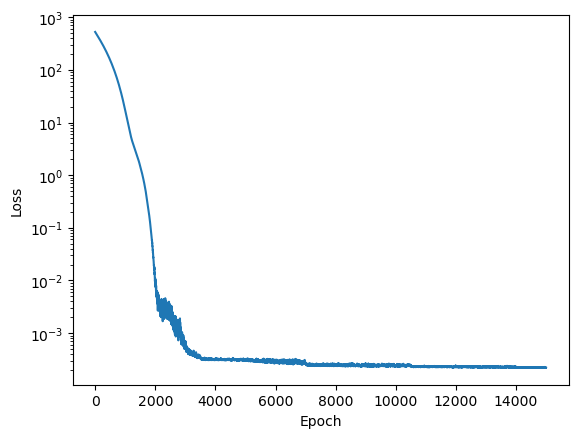

In [13]:
plt.plot(Loss_data.detach().cpu().numpy())
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.yscale("log")
plt.show()

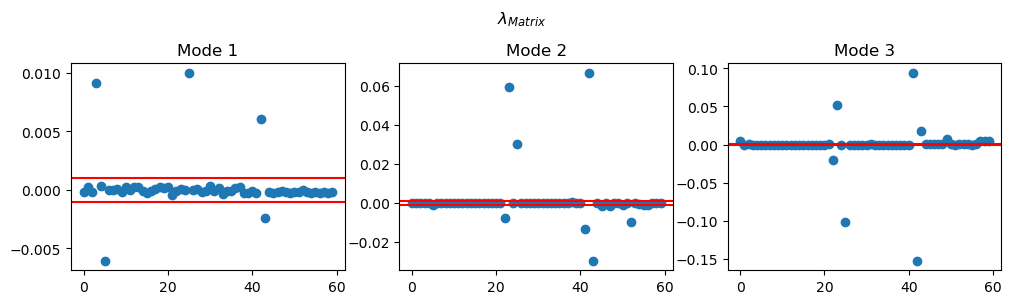

In [14]:
threshold = 0.001
#****************************************************************************#
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize =(12, 3))
fig.suptitle('$\lambda_{Matrix}$')

ax[0].plot(COEFF_ADT [:, 0].detach().cpu().numpy(), 'o') 
ax[0].set_title('Mode 1')
ax[0].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[0].axhline(y = -threshold, color = 'r', linestyle = '-')

ax[1].plot(COEFF_ADT [:, 1].detach().cpu().numpy(), 'o') 
ax[1].set_title('Mode 2')
ax[1].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[1].axhline(y = -threshold, color = 'r', linestyle = '-')

ax[2].plot(COEFF_ADT [:, 2].detach().cpu().numpy(), 'o') 
ax[2].set_title('Mode 3')
ax[2].axhline(y = threshold, color = 'r', linestyle = '-')
ax[2].axhline(y = -threshold, color = 'r', linestyle = '-')
fig.subplots_adjust(top=0.8)
plt.show()


The optimised coefficient matrix is further reduced by assuming the terms to be zero within the chosen threshold (0.001). 

In [15]:
# TRUNCATED SINDy COEFFICIENTS
C1 = torch.clone(COEFF_ADT[:, 0]).detach()
C1 [torch.logical_and(C1 >= -threshold, C1 <=threshold)] = 0.0

C2 = torch.clone(COEFF_ADT[:, 1]).detach()
C2 [torch.logical_and(C2 >= -threshold, C2 <=threshold)] = 0.0

C3 = torch.clone(COEFF_ADT[:, 2]).detach()
C3 [torch.logical_and(C3 >= -threshold, C3 <=threshold)] = 0.0

In [16]:
A1_DT_Predict = A1_DT (A_candidates)
A2_DT_Predict = A2_DT (A_candidates)
A3_DT_Predict = A3_DT (A_candidates)

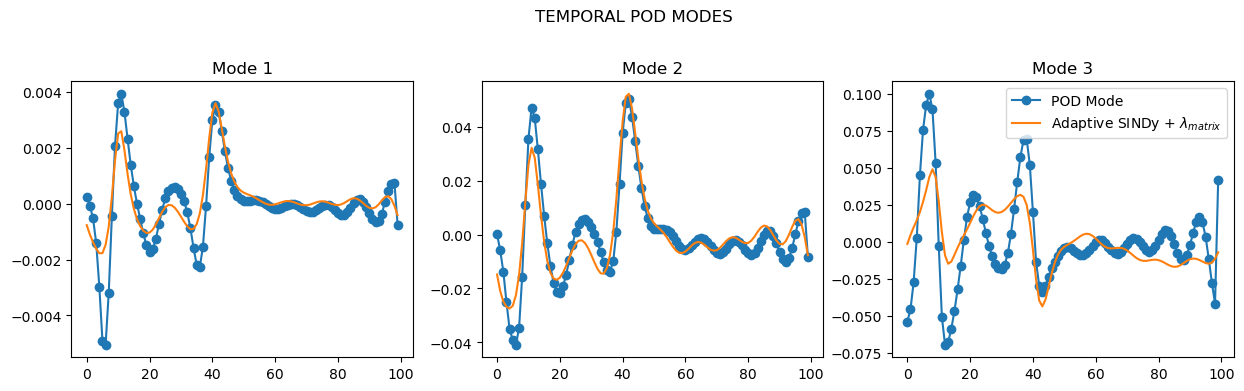

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize =(15, 4))
fig.suptitle('TEMPORAL POD MODES')

ax[0].plot(A1A2A3_time_deriv[0, :].detach().cpu().numpy(), '-o', label = "POD Mode") 
ax[0].plot(A1_DT_Predict.detach().cpu().numpy(), label = "SINDy") 
ax[0].set_title('Mode 1')


ax[1].plot(A1A2A3_time_deriv[1, :].detach().cpu().numpy(), '-o', label = "POD Mode") 
ax[1].plot(A2_DT_Predict.detach().cpu().numpy(), label = "SINDy - $\lambda_{matrix}$") 
ax[1].set_title('Mode 2')


ax[2].plot(A1A2A3_time_deriv[2, :].detach().cpu().numpy(), '-o', label = "POD Mode") 
ax[2].plot(A3_DT_Predict.detach().cpu().numpy(), label = "Adaptive SINDy + $\lambda_{matrix}$")
ax[2].legend()
ax[2].set_title('Mode 3')

fig.subplots_adjust(top=0.8)
plt.show()